In [1]:
import os, csv, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
results_path_256 = './3500_results/256GB/graphs/results.csv'
results_path_8 = './3500_results/8GB/graphs/results.csv'
results_path_4 = './3500_results/4GB/graphs/results.csv'

/home/glatard/venvs/jupyter/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-3-304383656843>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ref_names)


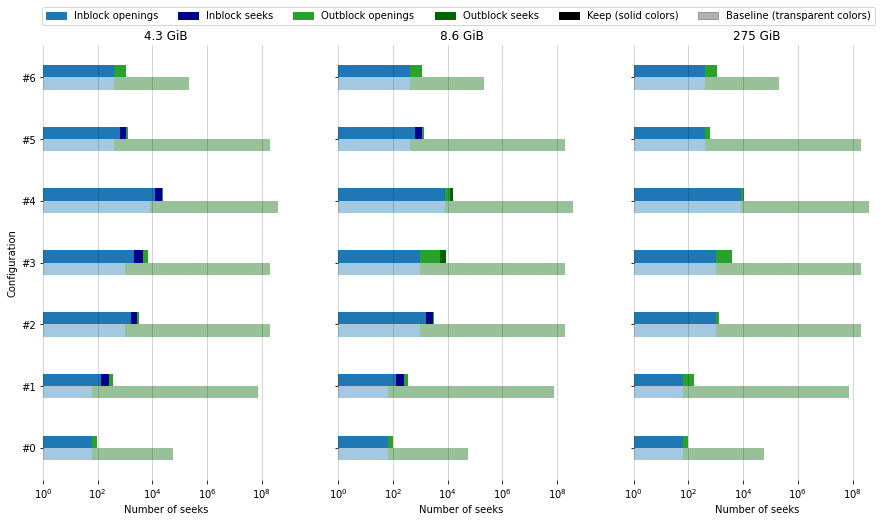

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 8), sharey=True)
for ax in (ax1, ax2, ax3):
    ax.grid(True, axis='x', which='both', color='black', alpha=0.2, zorder=0)
    ax.set_xlim(1, 10**9)


def compute_graph(results_path, ax, title, legend=False, first=False):
    df = pd.read_csv(results_path)
    df_seeks = pd.read_csv(results_path)

    df_seeks = df_seeks.drop(columns=['Unnamed: 0', 'case_name', 'process_time', 'preprocess_time', 'read_time', 'write_time', 'max_voxels', 'success'])
    
    df_keep = df_seeks.loc[df_seeks["model"]=="keep"]
    keep_means = df_keep.groupby('run_ref').mean()
    keep_stds = df_keep.groupby('run_ref').std()
    
    df_baseline = df_seeks.loc[df_seeks["model"]=="baseline"]
    baseline_means = df_baseline.groupby('run_ref').mean()
    baseline_stds = df_baseline.groupby('run_ref').std()

    # preprocessing
    df = df.drop(columns=['max_voxels', 'success', 'case_name', 'Unnamed: 0'])
    df = df.drop(columns=['outfile_openings', 'outfile_seeks', 'infile_openings', 'infile_seeks'])
    references = df["run_ref"].unique()
    models = df["model"].unique()
    
    outseeks_bottom_k = keep_means['infile_openings'] + keep_means['infile_seeks'] + keep_means['outfile_openings']
    outops_bottom_k = keep_means['infile_openings'] + keep_means['infile_seeks'] 
    inseeks_bottom_k = keep_means['infile_openings'] 

    outseeks_bottom_b = baseline_means['infile_openings'] + baseline_means['infile_seeks'] + baseline_means['outfile_openings']
    outops_bottom_b = baseline_means['infile_openings'] + baseline_means['infile_seeks'] 
    inseeks_bottom_b = baseline_means['infile_openings'] 

    
    x = np.arange(len(references))  # the label locations
    
    width = 0.20  # the width of the bars
    width_step = [width /2, width /2]
    
    _ = ax.barh(x - width/2, baseline_means['infile_openings'], width, yerr=baseline_stds['infile_openings'], label='infile_openings (baseline)', color=['tab:blue'], alpha=0.4)
    _ = ax.barh(x - width/2, baseline_means['infile_seeks'], width, left=inseeks_bottom_b, yerr=baseline_stds['infile_seeks'], label='infile_seeks (baseline)', color=['darkblue'], alpha=0.4)
    _ = ax.barh(x - width/2, baseline_means['outfile_openings'], width, left=outops_bottom_b, yerr=baseline_stds['outfile_openings'], label='outfile_openings (baseline)', color=['tab:green'], alpha=0.4)
    _ = ax.barh(x - width/2, baseline_means['outfile_seeks'], width, left=outseeks_bottom_b, yerr=baseline_stds['outfile_seeks'], label='outfile_seeks (baseline)', color=['darkgreen'], alpha=0.4)
    
    _ = ax.barh(x + width/2, keep_means['infile_openings'], width, yerr=keep_stds['infile_openings'], label='infile_openings (keep)', color=['tab:blue'])
    _ = ax.barh(x + width/2, keep_means['infile_seeks'], width, left=inseeks_bottom_k, yerr=keep_stds['infile_seeks'], label='infile_seeks (keep)', color=['darkblue'])
    _ = ax.barh(x + width/2, keep_means['outfile_openings'], width, left=outops_bottom_k, yerr=keep_stds['outfile_openings'], label='outfile_openings (keep)', color=['tab:green'])
    _ = ax.barh(x + width/2, keep_means['outfile_seeks'], width, left=outseeks_bottom_k, yerr=keep_stds['outfile_seeks'], label='outfile_seeks (keep)', color=['darkgreen'])
    
    ax.set_xlabel('Number of seeks')
    if first:
        ax.set_ylabel('Configuration')
    ax.set_title(title)
    ax.set_xscale('log')
    
    ref_names = sorted(references)
    ref_names = [""] + list(map(lambda x: "#" + str(x), ref_names))
    ax.set_yticklabels(ref_names)
    
    return 

compute_graph(results_path_4, ax1, '4.3 GiB', legend=False, first=True)
compute_graph(results_path_8, ax2, '8.6 GiB', legend=False)
compute_graph(results_path_256, ax3, '275 GiB', legend=True)
for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)

    
import matplotlib.patches as mpatches
p1 = mpatches.Patch(color='tab:green', label='Outblock openings')
p2 = mpatches.Patch(color='darkgreen', label='Outblock seeks')
p3 = mpatches.Patch(color='tab:blue', label='Inblock openings')
p4 = mpatches.Patch(color='darkblue', label='Inblock seeks')
p5 = mpatches.Patch(color='black', label='Keep (solid colors)')
p6 = mpatches.Patch(color='black', alpha=0.3, label='Baseline (transparent colors)')
plt.legend(handles=[p3, p4, p1, p2, p5, p6], ncol=6, bbox_to_anchor=(1., 1.1))
plt.savefig('../../rechunk-paper/figures/seeks_3500.pdf', bbox_inches="tight")
